## library


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

## Constant

In [8]:
BATCH_SIZE = 32
EPOCHS = 250
LEARNING_RATE = 0.0001
NUM_BANDS = 100  
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PATIENCE = 20  

In [4]:
# Load training and test data
train_df = pd.read_csv('C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/train.csv')
test_df = pd.read_csv('C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/test.csv')
base_path = 'C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot'

## Data Explore

 Removing: 2451, 47 (Too Noisy)

## CNN

In [5]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(concat))
        return x * attention

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return out.view(b, c, 1, 1)

class HyperspectralCNN(nn.Module):
    def __init__(self, in_channels=NUM_BANDS):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca1 = ChannelAttention(64)
        self.sa1 = SpatialAttention()
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca2 = ChannelAttention(128)
        self.sa2 = SpatialAttention()
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Regression head to predict the score
        self.regressor = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Sigmoid to output between 0 and 1
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.ca1(x) * x
        x = self.sa1(x) * x
        
        x = self.conv2(x)
        x = self.ca2(x) * x
        x = self.sa2(x) * x
        
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        return x * 100  # Scale to 0-100 range


## Data set


In [6]:
class HyperspectralDataset(Dataset):
    def __init__(self, df, base_path, patch_size=64, augment=False, is_test=False):
        self.df = df
        self.base_path = base_path
        self.patch_size = patch_size
        self.augment = augment
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get the NPY file path from the dataframe
        npy_file = self.df.iloc[idx]['id']  # Using 'id' column for both train and test
        
        # Load the NPY file
        data = np.load(f"{self.base_path}/{npy_file}")
        data = torch.from_numpy(data).float()
        
        # Reshape data to (channels, height, width)
        # Assuming input is (height, width, channels)
        if len(data.shape) == 3:
            data = data.permute(2, 0, 1)  # Change from (H, W, C) to (C, H, W)
        
        # Ensure we have exactly NUM_BANDS channels
        if data.shape[0] != NUM_BANDS:
            # If we have more channels, take the first NUM_BANDS
            # If we have fewer channels, pad with zeros
            if data.shape[0] > NUM_BANDS:
                data = data[:NUM_BANDS]
            else:
                padding = torch.zeros((NUM_BANDS - data.shape[0], data.shape[1], data.shape[2]))
                data = torch.cat([data, padding], dim=0)
        
        # Resize to fixed size using interpolation
        if data.shape[1] != self.patch_size or data.shape[2] != self.patch_size:
            data = F.interpolate(data.unsqueeze(0), size=(self.patch_size, self.patch_size), 
                               mode='bilinear', align_corners=False).squeeze(0)
        
        # Normalize data
        data = (data - data.mean()) / (data.std() + 1e-8)
        
        if self.is_test:
            # For test data, return only the data
            return data
        else:
            # For training data, return data and label
            disease_percentage = torch.tensor(self.df.iloc[idx]['label'], dtype=torch.float32)
            return data, disease_percentage

## Epoch Loop

In [7]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
    train_losses = []
    train_maes = []  # Mean Absolute Error
    val_losses = []
    val_maes = []
    
    early_stopping = EarlyStopping(patience=PATIENCE)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        valid_samples = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                continue
                
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if torch.isnan(outputs).any():
                continue
                
            # Reshape outputs to match labels
            outputs = outputs.squeeze(-1)  # Remove last dimension if it's 1
            labels = labels.float()  # Ensure labels are float
            
            loss = criterion(outputs, labels) 
            
            if not torch.isnan(loss):
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
                train_mae += torch.abs(outputs - labels).sum().item()
                valid_samples += inputs.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_samples = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                outputs = outputs.squeeze(-1)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_mae += torch.abs(outputs - labels).sum().item()
                val_samples += inputs.size(0)
        
        if valid_samples > 0 and val_samples > 0:
            train_loss /= valid_samples
            train_mae /= valid_samples
            val_loss /= val_samples
            val_mae /= val_samples
            
            train_losses.append(train_loss)
            train_maes.append(train_mae)
            val_losses.append(val_loss)
            val_maes.append(val_mae)
            
            print(f"Epoch {epoch+1}:")
            print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.2f}%")
            
            # Save model after each epoch
            torch.save(model.state_dict(), 'disease_regression_model.pth')
            
            # Early stopping check
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        else:
            print(f"Epoch {epoch+1}: No valid training/validation samples")
    
    # Plot training curves
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot MAE
    ax2.plot(train_maes, label='Train MAE', marker='o')
    ax2.plot(val_maes, label='Val MAE', marker='o')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE (%)')
    ax2.set_title('Training and Validation Mean Absolute Error')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model

def evaluate_model(model, loader, criterion, device=DEVICE):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_mae += torch.abs(outputs - labels).sum().item()
            
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader.dataset)
    avg_mae = total_mae / len(loader.dataset)
    
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test MAE: {avg_mae:.2f}%")
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(all_labels, all_preds, alpha=0.5)
    plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
    plt.xlabel('Actual Disease Percentage')
    plt.ylabel('Predicted Disease Percentage')
    plt.title('Predicted vs Actual Disease Percentage')
    plt.grid(True)
    plt.show()
    
    return avg_loss, np.array(all_preds), np.array(all_labels)

## Main

Epoch 1/250: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s]


Epoch 1:
Train Loss: 865.6071, Train MAE: 25.55%
Val Loss: 865.2531, Val MAE: 25.54%


Epoch 2/250: 100%|██████████| 68/68 [00:43<00:00,  1.57it/s]


Epoch 2:
Train Loss: 866.3973, Train MAE: 25.55%
Val Loss: 864.9741, Val MAE: 25.54%


Epoch 3/250: 100%|██████████| 68/68 [00:41<00:00,  1.66it/s]


Epoch 3:
Train Loss: 866.7595, Train MAE: 25.56%
Val Loss: 864.7408, Val MAE: 25.53%


Epoch 4/250: 100%|██████████| 68/68 [00:42<00:00,  1.60it/s]


Epoch 4:
Train Loss: 865.1678, Train MAE: 25.55%
Val Loss: 863.4683, Val MAE: 25.51%


Epoch 5/250: 100%|██████████| 68/68 [00:40<00:00,  1.68it/s]


Epoch 5:
Train Loss: 864.5799, Train MAE: 25.54%
Val Loss: 862.1580, Val MAE: 25.50%


Epoch 6/250: 100%|██████████| 68/68 [00:37<00:00,  1.79it/s]


Epoch 6:
Train Loss: 863.8632, Train MAE: 25.52%
Val Loss: 861.6215, Val MAE: 25.48%


Epoch 7/250: 100%|██████████| 68/68 [00:35<00:00,  1.90it/s]


Epoch 7:
Train Loss: 864.4557, Train MAE: 25.54%
Val Loss: 861.7877, Val MAE: 25.47%


Epoch 8/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 8:
Train Loss: 863.8976, Train MAE: 25.52%
Val Loss: 859.2750, Val MAE: 25.45%


Epoch 9/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 9:
Train Loss: 859.0907, Train MAE: 25.46%
Val Loss: 862.3303, Val MAE: 25.50%


Epoch 10/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 10:
Train Loss: 864.4855, Train MAE: 25.51%
Val Loss: 858.7029, Val MAE: 25.45%


Epoch 11/250: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s]


Epoch 11:
Train Loss: 862.9210, Train MAE: 25.49%
Val Loss: 858.1217, Val MAE: 25.41%


Epoch 12/250: 100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


Epoch 12:
Train Loss: 859.1620, Train MAE: 25.44%
Val Loss: 858.3652, Val MAE: 25.41%


Epoch 13/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 13:
Train Loss: 858.1358, Train MAE: 25.41%
Val Loss: 857.9665, Val MAE: 25.38%


Epoch 14/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 14:
Train Loss: 856.6488, Train MAE: 25.37%
Val Loss: 852.3247, Val MAE: 25.34%


Epoch 15/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 15:
Train Loss: 855.4975, Train MAE: 25.35%
Val Loss: 851.4578, Val MAE: 25.28%


Epoch 16/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 16:
Train Loss: 852.4451, Train MAE: 25.32%
Val Loss: 845.3312, Val MAE: 25.13%


Epoch 17/250: 100%|██████████| 68/68 [00:36<00:00,  1.89it/s]


Epoch 17:
Train Loss: 849.9594, Train MAE: 25.29%
Val Loss: 848.3595, Val MAE: 25.24%


Epoch 18/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 18:
Train Loss: 850.1118, Train MAE: 25.30%
Val Loss: 844.6910, Val MAE: 25.12%


Epoch 19/250: 100%|██████████| 68/68 [00:34<00:00,  1.97it/s]


Epoch 19:
Train Loss: 844.9543, Train MAE: 25.14%
Val Loss: 837.7595, Val MAE: 25.01%


Epoch 20/250: 100%|██████████| 68/68 [00:35<00:00,  1.94it/s]


Epoch 20:
Train Loss: 833.1423, Train MAE: 24.93%
Val Loss: 828.9545, Val MAE: 24.89%


Epoch 21/250: 100%|██████████| 68/68 [00:35<00:00,  1.93it/s]


Epoch 21:
Train Loss: 835.3972, Train MAE: 24.96%
Val Loss: 829.8201, Val MAE: 24.81%


Epoch 22/250: 100%|██████████| 68/68 [00:35<00:00,  1.94it/s]


Epoch 22:
Train Loss: 827.7115, Train MAE: 24.80%
Val Loss: 825.9269, Val MAE: 24.82%


Epoch 23/250: 100%|██████████| 68/68 [00:35<00:00,  1.92it/s]


Epoch 23:
Train Loss: 824.2139, Train MAE: 24.76%
Val Loss: 828.9895, Val MAE: 24.89%


Epoch 24/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 24:
Train Loss: 817.9630, Train MAE: 24.65%
Val Loss: 814.7396, Val MAE: 24.64%


Epoch 25/250: 100%|██████████| 68/68 [00:36<00:00,  1.89it/s]


Epoch 25:
Train Loss: 821.7467, Train MAE: 24.63%
Val Loss: 801.7176, Val MAE: 24.36%


Epoch 26/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 26:
Train Loss: 812.2792, Train MAE: 24.51%
Val Loss: 821.3254, Val MAE: 24.71%


Epoch 27/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 27:
Train Loss: 803.7576, Train MAE: 24.32%
Val Loss: 806.5876, Val MAE: 24.47%


Epoch 28/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 28:
Train Loss: 802.0788, Train MAE: 24.23%
Val Loss: 789.5254, Val MAE: 24.06%


Epoch 29/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 29:
Train Loss: 798.8426, Train MAE: 24.21%
Val Loss: 794.2989, Val MAE: 24.24%


Epoch 30/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 30:
Train Loss: 787.4680, Train MAE: 23.97%
Val Loss: 797.6123, Val MAE: 24.33%


Epoch 31/250: 100%|██████████| 68/68 [00:35<00:00,  1.94it/s]


Epoch 31:
Train Loss: 788.4708, Train MAE: 24.01%
Val Loss: 790.0569, Val MAE: 24.11%


Epoch 32/250: 100%|██████████| 68/68 [00:35<00:00,  1.93it/s]


Epoch 32:
Train Loss: 785.3160, Train MAE: 23.93%
Val Loss: 777.0705, Val MAE: 23.90%


Epoch 33/250: 100%|██████████| 68/68 [00:35<00:00,  1.94it/s]


Epoch 33:
Train Loss: 774.0950, Train MAE: 23.66%
Val Loss: 769.5158, Val MAE: 23.70%


Epoch 34/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 34:
Train Loss: 773.1887, Train MAE: 23.67%
Val Loss: 760.8306, Val MAE: 23.42%


Epoch 35/250: 100%|██████████| 68/68 [00:35<00:00,  1.90it/s]


Epoch 35:
Train Loss: 769.8729, Train MAE: 23.58%
Val Loss: 750.3530, Val MAE: 23.08%


Epoch 36/250: 100%|██████████| 68/68 [00:35<00:00,  1.91it/s]


Epoch 36:
Train Loss: 773.2994, Train MAE: 23.62%
Val Loss: 749.2688, Val MAE: 23.12%


Epoch 37/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 37:
Train Loss: 761.5693, Train MAE: 23.39%
Val Loss: 751.3060, Val MAE: 23.20%


Epoch 38/250: 100%|██████████| 68/68 [00:35<00:00,  1.91it/s]


Epoch 38:
Train Loss: 768.2211, Train MAE: 23.51%
Val Loss: 757.0260, Val MAE: 23.37%


Epoch 39/250: 100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


Epoch 39:
Train Loss: 763.3890, Train MAE: 23.47%
Val Loss: 740.5496, Val MAE: 22.94%


Epoch 40/250: 100%|██████████| 68/68 [00:35<00:00,  1.90it/s]


Epoch 40:
Train Loss: 756.8586, Train MAE: 23.19%
Val Loss: 741.5875, Val MAE: 22.95%


Epoch 41/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 41:
Train Loss: 751.5015, Train MAE: 23.14%
Val Loss: 764.6769, Val MAE: 23.67%


Epoch 42/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 42:
Train Loss: 754.9182, Train MAE: 23.25%
Val Loss: 741.1491, Val MAE: 22.89%


Epoch 43/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 43:
Train Loss: 742.3400, Train MAE: 22.89%
Val Loss: 740.9680, Val MAE: 23.01%


Epoch 44/250: 100%|██████████| 68/68 [00:35<00:00,  1.93it/s]


Epoch 44:
Train Loss: 743.3251, Train MAE: 23.04%
Val Loss: 720.5465, Val MAE: 22.41%


Epoch 45/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 45:
Train Loss: 754.2819, Train MAE: 23.21%
Val Loss: 736.6438, Val MAE: 23.03%


Epoch 46/250: 100%|██████████| 68/68 [00:35<00:00,  1.94it/s]


Epoch 46:
Train Loss: 729.1397, Train MAE: 22.60%
Val Loss: 727.8677, Val MAE: 22.46%


Epoch 47/250: 100%|██████████| 68/68 [00:35<00:00,  1.90it/s]


Epoch 47:
Train Loss: 725.0774, Train MAE: 22.47%
Val Loss: 732.0694, Val MAE: 22.85%


Epoch 48/250: 100%|██████████| 68/68 [00:35<00:00,  1.91it/s]


Epoch 48:
Train Loss: 740.3699, Train MAE: 22.83%
Val Loss: 720.4738, Val MAE: 22.62%


Epoch 49/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 49:
Train Loss: 738.3272, Train MAE: 22.83%
Val Loss: 715.2670, Val MAE: 22.44%


Epoch 50/250: 100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


Epoch 50:
Train Loss: 731.7997, Train MAE: 22.67%
Val Loss: 699.2512, Val MAE: 21.98%


Epoch 51/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 51:
Train Loss: 725.0434, Train MAE: 22.52%
Val Loss: 705.8614, Val MAE: 22.29%


Epoch 52/250: 100%|██████████| 68/68 [00:36<00:00,  1.89it/s]


Epoch 52:
Train Loss: 713.7913, Train MAE: 22.26%
Val Loss: 745.2948, Val MAE: 23.25%


Epoch 53/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 53:
Train Loss: 710.5612, Train MAE: 22.19%
Val Loss: 695.8196, Val MAE: 21.95%


Epoch 54/250: 100%|██████████| 68/68 [00:37<00:00,  1.84it/s]


Epoch 54:
Train Loss: 716.5561, Train MAE: 22.31%
Val Loss: 690.2586, Val MAE: 21.84%


Epoch 55/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 55:
Train Loss: 705.4521, Train MAE: 22.13%
Val Loss: 679.0063, Val MAE: 21.57%


Epoch 56/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 56:
Train Loss: 706.9938, Train MAE: 22.11%
Val Loss: 682.5444, Val MAE: 21.65%


Epoch 57/250: 100%|██████████| 68/68 [00:34<00:00,  1.95it/s]


Epoch 57:
Train Loss: 700.6595, Train MAE: 22.16%
Val Loss: 666.8244, Val MAE: 21.27%


Epoch 58/250: 100%|██████████| 68/68 [00:35<00:00,  1.92it/s]


Epoch 58:
Train Loss: 695.4224, Train MAE: 21.84%
Val Loss: 660.9223, Val MAE: 21.12%


Epoch 59/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 59:
Train Loss: 691.4894, Train MAE: 21.88%
Val Loss: 661.1824, Val MAE: 21.23%


Epoch 60/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 60:
Train Loss: 688.2754, Train MAE: 21.61%
Val Loss: 664.9629, Val MAE: 21.37%


Epoch 61/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 61:
Train Loss: 680.3691, Train MAE: 21.47%
Val Loss: 638.6538, Val MAE: 20.66%


Epoch 62/250: 100%|██████████| 68/68 [00:35<00:00,  1.89it/s]


Epoch 62:
Train Loss: 668.4238, Train MAE: 21.38%
Val Loss: 653.4005, Val MAE: 21.21%


Epoch 63/250: 100%|██████████| 68/68 [00:36<00:00,  1.89it/s]


Epoch 63:
Train Loss: 673.9021, Train MAE: 21.53%
Val Loss: 650.4773, Val MAE: 20.87%


Epoch 64/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 64:
Train Loss: 658.8974, Train MAE: 21.11%
Val Loss: 629.9625, Val MAE: 20.53%


Epoch 65/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 65:
Train Loss: 640.9348, Train MAE: 20.73%
Val Loss: 620.4344, Val MAE: 20.09%


Epoch 66/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 66:
Train Loss: 654.1530, Train MAE: 20.99%
Val Loss: 633.1714, Val MAE: 20.33%


Epoch 67/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 67:
Train Loss: 644.9453, Train MAE: 20.80%
Val Loss: 611.5176, Val MAE: 20.12%


Epoch 68/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 68:
Train Loss: 624.8594, Train MAE: 20.35%
Val Loss: 591.5992, Val MAE: 19.53%


Epoch 69/250: 100%|██████████| 68/68 [00:35<00:00,  1.93it/s]


Epoch 69:
Train Loss: 636.2311, Train MAE: 20.54%
Val Loss: 613.9556, Val MAE: 20.20%


Epoch 70/250: 100%|██████████| 68/68 [00:35<00:00,  1.92it/s]


Epoch 70:
Train Loss: 636.4043, Train MAE: 20.64%
Val Loss: 594.1348, Val MAE: 19.84%


Epoch 71/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 71:
Train Loss: 629.2149, Train MAE: 20.44%
Val Loss: 589.8549, Val MAE: 19.73%


Epoch 72/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 72:
Train Loss: 618.0386, Train MAE: 20.19%
Val Loss: 580.7465, Val MAE: 19.39%


Epoch 73/250: 100%|██████████| 68/68 [00:35<00:00,  1.90it/s]


Epoch 73:
Train Loss: 603.4060, Train MAE: 19.86%
Val Loss: 618.3666, Val MAE: 20.39%


Epoch 74/250: 100%|██████████| 68/68 [00:36<00:00,  1.89it/s]


Epoch 74:
Train Loss: 611.9978, Train MAE: 20.06%
Val Loss: 548.2498, Val MAE: 18.62%


Epoch 75/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 75:
Train Loss: 588.1854, Train MAE: 19.51%
Val Loss: 545.5554, Val MAE: 18.71%


Epoch 76/250: 100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


Epoch 76:
Train Loss: 592.1032, Train MAE: 19.69%
Val Loss: 620.1335, Val MAE: 19.72%


Epoch 77/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 77:
Train Loss: 587.1994, Train MAE: 19.66%
Val Loss: 593.2554, Val MAE: 19.82%


Epoch 78/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 78:
Train Loss: 585.7177, Train MAE: 19.62%
Val Loss: 558.7021, Val MAE: 18.67%


Epoch 79/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 79:
Train Loss: 574.7277, Train MAE: 19.34%
Val Loss: 538.3026, Val MAE: 18.38%


Epoch 80/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 80:
Train Loss: 558.2445, Train MAE: 18.90%
Val Loss: 543.7197, Val MAE: 18.59%


Epoch 81/250: 100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


Epoch 81:
Train Loss: 554.2061, Train MAE: 18.91%
Val Loss: 510.5949, Val MAE: 17.94%


Epoch 82/250: 100%|██████████| 68/68 [00:35<00:00,  1.94it/s]


Epoch 82:
Train Loss: 555.5137, Train MAE: 18.82%
Val Loss: 513.9505, Val MAE: 17.95%


Epoch 83/250: 100%|██████████| 68/68 [00:35<00:00,  1.90it/s]


Epoch 83:
Train Loss: 523.8110, Train MAE: 18.21%
Val Loss: 468.0058, Val MAE: 16.96%


Epoch 84/250: 100%|██████████| 68/68 [00:35<00:00,  1.90it/s]


Epoch 84:
Train Loss: 533.2075, Train MAE: 18.31%
Val Loss: 475.3628, Val MAE: 17.23%


Epoch 85/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 85:
Train Loss: 536.0214, Train MAE: 18.48%
Val Loss: 505.8026, Val MAE: 17.59%


Epoch 86/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 86:
Train Loss: 513.8537, Train MAE: 18.02%
Val Loss: 490.4283, Val MAE: 17.50%


Epoch 87/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 87:
Train Loss: 511.8659, Train MAE: 18.07%
Val Loss: 468.4535, Val MAE: 17.23%


Epoch 88/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 88:
Train Loss: 492.8577, Train MAE: 17.47%
Val Loss: 438.9907, Val MAE: 16.34%


Epoch 89/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 89:
Train Loss: 506.2620, Train MAE: 17.79%
Val Loss: 463.4538, Val MAE: 17.32%


Epoch 90/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 90:
Train Loss: 505.2779, Train MAE: 17.84%
Val Loss: 516.6449, Val MAE: 17.44%


Epoch 91/250: 100%|██████████| 68/68 [00:37<00:00,  1.81it/s]


Epoch 91:
Train Loss: 470.0110, Train MAE: 17.04%
Val Loss: 412.9235, Val MAE: 15.71%


Epoch 92/250: 100%|██████████| 68/68 [00:35<00:00,  1.89it/s]


Epoch 92:
Train Loss: 443.9365, Train MAE: 16.31%
Val Loss: 410.0488, Val MAE: 15.88%


Epoch 93/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 93:
Train Loss: 476.4085, Train MAE: 17.14%
Val Loss: 464.2206, Val MAE: 17.55%


Epoch 94/250: 100%|██████████| 68/68 [00:36<00:00,  1.89it/s]


Epoch 94:
Train Loss: 431.6910, Train MAE: 16.24%
Val Loss: 391.1554, Val MAE: 15.19%


Epoch 95/250: 100%|██████████| 68/68 [00:38<00:00,  1.77it/s]


Epoch 95:
Train Loss: 428.3093, Train MAE: 15.95%
Val Loss: 433.4095, Val MAE: 16.56%


Epoch 96/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 96:
Train Loss: 420.0448, Train MAE: 15.89%
Val Loss: 395.5520, Val MAE: 15.40%


Epoch 97/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 97:
Train Loss: 403.9850, Train MAE: 15.34%
Val Loss: 348.1645, Val MAE: 14.27%


Epoch 98/250: 100%|██████████| 68/68 [00:37<00:00,  1.81it/s]


Epoch 98:
Train Loss: 401.2625, Train MAE: 15.47%
Val Loss: 485.0543, Val MAE: 17.61%


Epoch 99/250: 100%|██████████| 68/68 [00:38<00:00,  1.77it/s]


Epoch 99:
Train Loss: 400.6225, Train MAE: 15.38%
Val Loss: 316.3052, Val MAE: 13.32%


Epoch 100/250: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s]


Epoch 100:
Train Loss: 393.8157, Train MAE: 15.32%
Val Loss: 316.1294, Val MAE: 13.35%


Epoch 101/250: 100%|██████████| 68/68 [00:37<00:00,  1.79it/s]


Epoch 101:
Train Loss: 375.7583, Train MAE: 14.94%
Val Loss: 304.2269, Val MAE: 13.18%


Epoch 102/250: 100%|██████████| 68/68 [00:37<00:00,  1.81it/s]


Epoch 102:
Train Loss: 381.7836, Train MAE: 14.99%
Val Loss: 336.6015, Val MAE: 14.49%


Epoch 103/250: 100%|██████████| 68/68 [00:38<00:00,  1.77it/s]


Epoch 103:
Train Loss: 349.7381, Train MAE: 14.15%
Val Loss: 290.5994, Val MAE: 12.79%


Epoch 104/250: 100%|██████████| 68/68 [00:37<00:00,  1.80it/s]


Epoch 104:
Train Loss: 359.0781, Train MAE: 14.52%
Val Loss: 303.8013, Val MAE: 13.27%


Epoch 105/250: 100%|██████████| 68/68 [00:37<00:00,  1.81it/s]


Epoch 105:
Train Loss: 359.8512, Train MAE: 14.58%
Val Loss: 301.5990, Val MAE: 13.13%


Epoch 106/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 106:
Train Loss: 348.6372, Train MAE: 14.29%
Val Loss: 290.4833, Val MAE: 12.63%


Epoch 107/250: 100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


Epoch 107:
Train Loss: 321.9910, Train MAE: 13.73%
Val Loss: 275.1893, Val MAE: 12.45%


Epoch 108/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 108:
Train Loss: 306.6484, Train MAE: 13.35%
Val Loss: 241.9310, Val MAE: 11.31%


Epoch 109/250: 100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


Epoch 109:
Train Loss: 304.3592, Train MAE: 13.17%
Val Loss: 280.2892, Val MAE: 12.83%


Epoch 110/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 110:
Train Loss: 291.5813, Train MAE: 12.75%
Val Loss: 264.7931, Val MAE: 12.35%


Epoch 111/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 111:
Train Loss: 295.5470, Train MAE: 12.92%
Val Loss: 247.9940, Val MAE: 11.33%


Epoch 112/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 112:
Train Loss: 289.2902, Train MAE: 12.71%
Val Loss: 332.2848, Val MAE: 13.95%


Epoch 113/250: 100%|██████████| 68/68 [00:37<00:00,  1.81it/s]


Epoch 113:
Train Loss: 273.9607, Train MAE: 12.39%
Val Loss: 220.0268, Val MAE: 10.76%


Epoch 114/250: 100%|██████████| 68/68 [00:37<00:00,  1.84it/s]


Epoch 114:
Train Loss: 277.6063, Train MAE: 12.47%
Val Loss: 261.7536, Val MAE: 12.49%


Epoch 115/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 115:
Train Loss: 273.2957, Train MAE: 12.31%
Val Loss: 232.4527, Val MAE: 11.43%


Epoch 116/250: 100%|██████████| 68/68 [00:37<00:00,  1.80it/s]


Epoch 116:
Train Loss: 273.2983, Train MAE: 12.30%
Val Loss: 207.4293, Val MAE: 10.48%


Epoch 117/250: 100%|██████████| 68/68 [00:37<00:00,  1.79it/s]


Epoch 117:
Train Loss: 240.3929, Train MAE: 11.56%
Val Loss: 230.9823, Val MAE: 11.25%


Epoch 118/250: 100%|██████████| 68/68 [00:37<00:00,  1.80it/s]


Epoch 118:
Train Loss: 261.9986, Train MAE: 12.11%
Val Loss: 204.4219, Val MAE: 10.48%


Epoch 119/250: 100%|██████████| 68/68 [00:35<00:00,  1.90it/s]


Epoch 119:
Train Loss: 243.8834, Train MAE: 11.67%
Val Loss: 244.4304, Val MAE: 11.74%


Epoch 120/250: 100%|██████████| 68/68 [00:35<00:00,  1.89it/s]


Epoch 120:
Train Loss: 243.2320, Train MAE: 11.49%
Val Loss: 212.0009, Val MAE: 10.55%


Epoch 121/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 121:
Train Loss: 248.1859, Train MAE: 11.87%
Val Loss: 263.1508, Val MAE: 12.70%


Epoch 122/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 122:
Train Loss: 241.4491, Train MAE: 11.52%
Val Loss: 188.5733, Val MAE: 10.05%


Epoch 123/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 123:
Train Loss: 223.8764, Train MAE: 10.98%
Val Loss: 322.5924, Val MAE: 14.06%


Epoch 124/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 124:
Train Loss: 241.6213, Train MAE: 11.57%
Val Loss: 161.3357, Val MAE: 8.64%


Epoch 125/250: 100%|██████████| 68/68 [00:37<00:00,  1.81it/s]


Epoch 125:
Train Loss: 232.6152, Train MAE: 11.22%
Val Loss: 164.2919, Val MAE: 8.97%


Epoch 126/250: 100%|██████████| 68/68 [00:37<00:00,  1.80it/s]


Epoch 126:
Train Loss: 226.4474, Train MAE: 11.15%
Val Loss: 190.1028, Val MAE: 10.00%


Epoch 127/250: 100%|██████████| 68/68 [00:37<00:00,  1.80it/s]


Epoch 127:
Train Loss: 222.8238, Train MAE: 11.03%
Val Loss: 185.1723, Val MAE: 9.88%


Epoch 128/250: 100%|██████████| 68/68 [00:37<00:00,  1.80it/s]


Epoch 128:
Train Loss: 208.4857, Train MAE: 10.68%
Val Loss: 141.0706, Val MAE: 7.95%


Epoch 129/250: 100%|██████████| 68/68 [00:37<00:00,  1.79it/s]


Epoch 129:
Train Loss: 190.4503, Train MAE: 9.92%
Val Loss: 166.5962, Val MAE: 8.89%


Epoch 130/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 130:
Train Loss: 201.0927, Train MAE: 10.37%
Val Loss: 154.1368, Val MAE: 8.76%


Epoch 131/250: 100%|██████████| 68/68 [00:35<00:00,  1.92it/s]


Epoch 131:
Train Loss: 193.4565, Train MAE: 9.99%
Val Loss: 144.3587, Val MAE: 8.34%


Epoch 132/250: 100%|██████████| 68/68 [00:35<00:00,  1.89it/s]


Epoch 132:
Train Loss: 195.5683, Train MAE: 10.11%
Val Loss: 209.9951, Val MAE: 11.05%


Epoch 133/250: 100%|██████████| 68/68 [00:36<00:00,  1.89it/s]


Epoch 133:
Train Loss: 204.4299, Train MAE: 10.47%
Val Loss: 150.6388, Val MAE: 8.52%


Epoch 134/250: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]


Epoch 134:
Train Loss: 182.9852, Train MAE: 9.79%
Val Loss: 256.3407, Val MAE: 12.92%


Epoch 135/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 135:
Train Loss: 191.5660, Train MAE: 10.08%
Val Loss: 143.1905, Val MAE: 8.22%


Epoch 136/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 136:
Train Loss: 211.1750, Train MAE: 10.67%
Val Loss: 141.1456, Val MAE: 8.11%


Epoch 137/250: 100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


Epoch 137:
Train Loss: 181.2016, Train MAE: 9.68%
Val Loss: 131.4141, Val MAE: 7.66%


Epoch 138/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 138:
Train Loss: 181.1048, Train MAE: 9.64%
Val Loss: 149.8580, Val MAE: 8.54%


Epoch 139/250: 100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


Epoch 139:
Train Loss: 178.2973, Train MAE: 9.61%
Val Loss: 123.6457, Val MAE: 7.24%


Epoch 140/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 140:
Train Loss: 168.8307, Train MAE: 9.29%
Val Loss: 125.4511, Val MAE: 7.33%


Epoch 141/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 141:
Train Loss: 181.2453, Train MAE: 9.64%
Val Loss: 172.5241, Val MAE: 9.66%


Epoch 142/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 142:
Train Loss: 181.0888, Train MAE: 9.70%
Val Loss: 175.9804, Val MAE: 9.61%


Epoch 143/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 143:
Train Loss: 174.9352, Train MAE: 9.52%
Val Loss: 148.0753, Val MAE: 8.45%


Epoch 144/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 144:
Train Loss: 177.8998, Train MAE: 9.49%
Val Loss: 172.4093, Val MAE: 9.43%


Epoch 145/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 145:
Train Loss: 185.9013, Train MAE: 9.81%
Val Loss: 124.2133, Val MAE: 7.23%


Epoch 146/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 146:
Train Loss: 168.5010, Train MAE: 9.30%
Val Loss: 123.9696, Val MAE: 7.21%


Epoch 147/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 147:
Train Loss: 167.1446, Train MAE: 9.23%
Val Loss: 196.9476, Val MAE: 11.11%


Epoch 148/250: 100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


Epoch 148:
Train Loss: 179.1117, Train MAE: 9.66%
Val Loss: 130.0945, Val MAE: 7.65%


Epoch 149/250: 100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


Epoch 149:
Train Loss: 180.0126, Train MAE: 9.72%
Val Loss: 135.5315, Val MAE: 7.97%


Epoch 150/250: 100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


Epoch 150:
Train Loss: 164.7567, Train MAE: 9.17%
Val Loss: 250.5222, Val MAE: 12.00%


Epoch 151/250: 100%|██████████| 68/68 [00:37<00:00,  1.81it/s]


Epoch 151:
Train Loss: 176.3012, Train MAE: 9.54%
Val Loss: 121.6706, Val MAE: 7.15%


Epoch 152/250: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s]


Epoch 152:
Train Loss: 165.1493, Train MAE: 9.02%
Val Loss: 134.5474, Val MAE: 7.83%


Epoch 153/250: 100%|██████████| 68/68 [00:37<00:00,  1.79it/s]


Epoch 153:
Train Loss: 151.9698, Train MAE: 8.71%
Val Loss: 133.1975, Val MAE: 7.88%


Epoch 154/250: 100%|██████████| 68/68 [00:37<00:00,  1.79it/s]


Epoch 154:
Train Loss: 160.0100, Train MAE: 8.97%
Val Loss: 128.9952, Val MAE: 7.42%


Epoch 155/250: 100%|██████████| 68/68 [00:38<00:00,  1.77it/s]


Epoch 155:
Train Loss: 151.3822, Train MAE: 8.60%
Val Loss: 115.4974, Val MAE: 6.80%


Epoch 156/250: 100%|██████████| 68/68 [00:35<00:00,  1.90it/s]


Epoch 156:
Train Loss: 153.6557, Train MAE: 8.62%
Val Loss: 119.0870, Val MAE: 6.96%


Epoch 157/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 157:
Train Loss: 156.0118, Train MAE: 8.77%
Val Loss: 122.0827, Val MAE: 7.28%


Epoch 158/250: 100%|██████████| 68/68 [00:37<00:00,  1.79it/s]


Epoch 158:
Train Loss: 162.8428, Train MAE: 9.05%
Val Loss: 176.7290, Val MAE: 9.90%


Epoch 159/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 159:
Train Loss: 160.9746, Train MAE: 9.04%
Val Loss: 119.8250, Val MAE: 7.09%


Epoch 160/250: 100%|██████████| 68/68 [00:37<00:00,  1.80it/s]


Epoch 160:
Train Loss: 163.1204, Train MAE: 9.05%
Val Loss: 134.3931, Val MAE: 8.00%


Epoch 161/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 161:
Train Loss: 161.5940, Train MAE: 8.96%
Val Loss: 116.5203, Val MAE: 6.87%


Epoch 162/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 162:
Train Loss: 156.5426, Train MAE: 8.70%
Val Loss: 126.8882, Val MAE: 7.52%


Epoch 163/250: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


Epoch 163:
Train Loss: 149.4672, Train MAE: 8.52%
Val Loss: 117.3535, Val MAE: 6.88%


Epoch 164/250: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s]


Epoch 164:
Train Loss: 146.4038, Train MAE: 8.36%
Val Loss: 124.4689, Val MAE: 7.39%


Epoch 165/250: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s]


Epoch 165:
Train Loss: 150.3116, Train MAE: 8.58%
Val Loss: 134.9650, Val MAE: 7.95%


Epoch 166/250: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s]


Epoch 166:
Train Loss: 164.1353, Train MAE: 9.04%
Val Loss: 150.6505, Val MAE: 8.70%


Epoch 167/250: 100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


Epoch 167:
Train Loss: 163.2160, Train MAE: 9.04%
Val Loss: 192.0571, Val MAE: 10.23%


Epoch 168/250: 100%|██████████| 68/68 [00:36<00:00,  1.88it/s]


Epoch 168:
Train Loss: 154.5003, Train MAE: 8.71%
Val Loss: 116.6423, Val MAE: 6.92%


Epoch 169/250: 100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


Epoch 169:
Train Loss: 149.4662, Train MAE: 8.46%
Val Loss: 119.4853, Val MAE: 6.97%


Epoch 170/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 170:
Train Loss: 152.2062, Train MAE: 8.69%
Val Loss: 118.8962, Val MAE: 7.05%


Epoch 171/250: 100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


Epoch 171:
Train Loss: 155.2795, Train MAE: 8.68%
Val Loss: 118.0258, Val MAE: 6.96%


Epoch 172/250: 100%|██████████| 68/68 [00:41<00:00,  1.63it/s]


Epoch 172:
Train Loss: 145.5580, Train MAE: 8.31%
Val Loss: 121.6841, Val MAE: 7.35%


Epoch 173/250: 100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


Epoch 173:
Train Loss: 148.2717, Train MAE: 8.39%
Val Loss: 147.4169, Val MAE: 8.74%


Epoch 174/250: 100%|██████████| 68/68 [00:37<00:00,  1.80it/s]


Epoch 174:
Train Loss: 156.7253, Train MAE: 8.69%
Val Loss: 117.4635, Val MAE: 6.89%


Epoch 175/250: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s]


Epoch 175:
Train Loss: 143.0566, Train MAE: 8.18%
Val Loss: 125.7111, Val MAE: 7.51%
Early stopping triggered at epoch 175


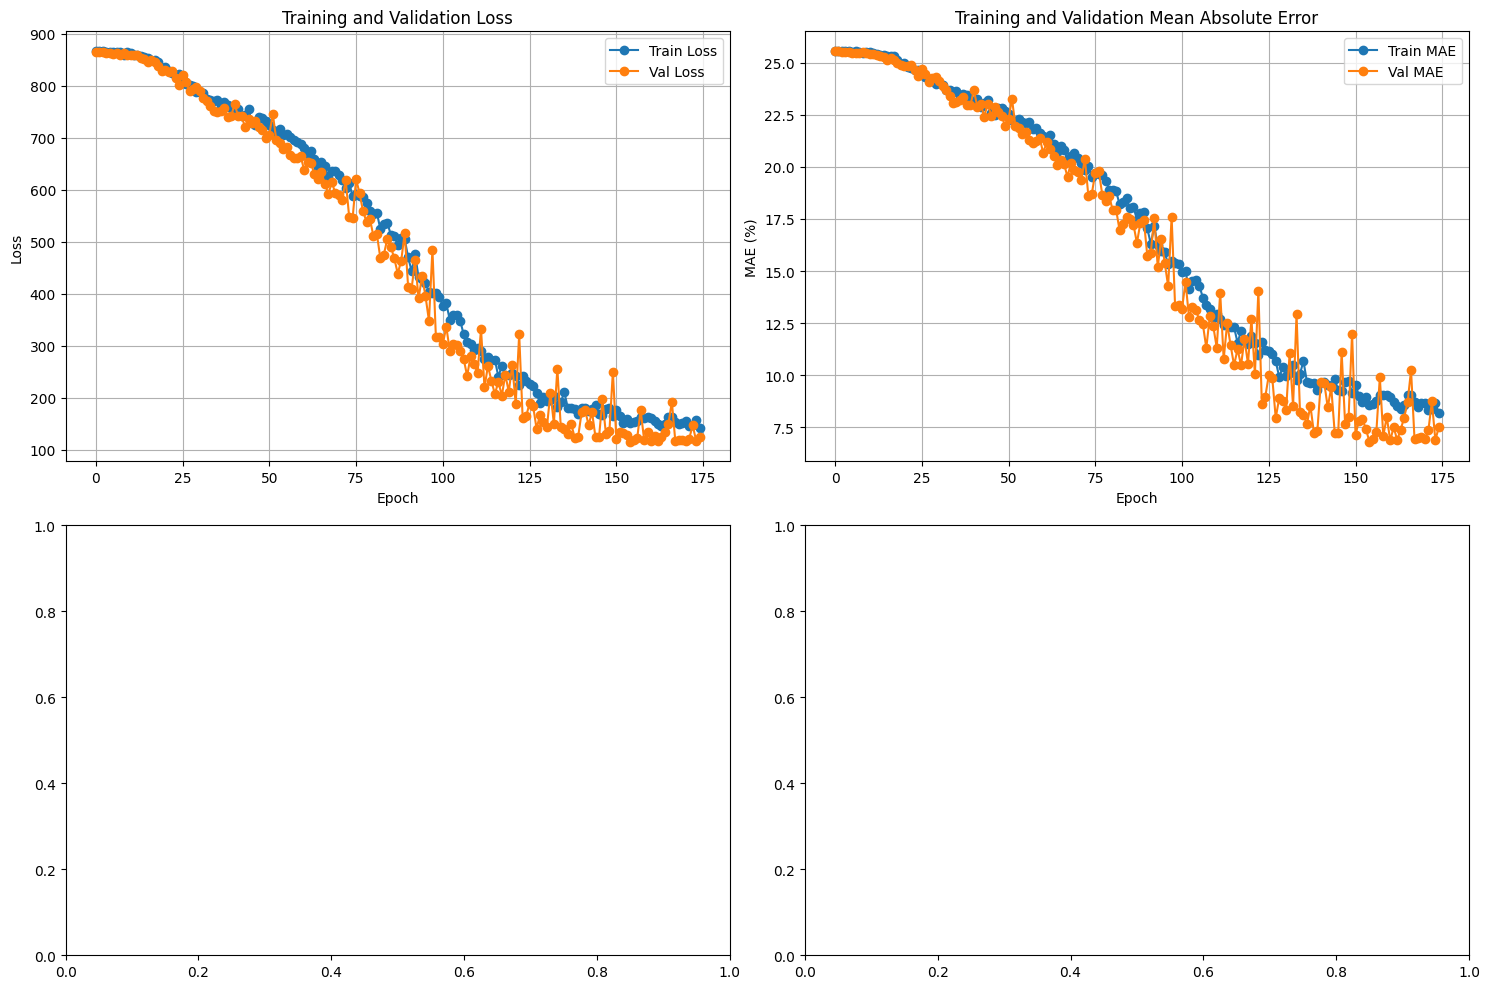

Making predictions: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


In [9]:
# Create datasets
train_dataset = HyperspectralDataset(train_df, base_path, augment=True, is_test=False)
val_dataset = HyperspectralDataset(train_df, base_path, augment=False, is_test=False) 
test_dataset = HyperspectralDataset(test_df, base_path, augment=False, is_test=True)

# Create data loaders with num_workers=0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Initialize model and training components
model = HyperspectralCNN().to(DEVICE)
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Train model
model = train_model(model, train_loader, val_loader, EPOCHS, criterion, optimizer)

# Make predictions on test set
model.eval()
all_preds = []
all_files = []

with torch.no_grad():
    for inputs in tqdm(test_loader, desc="Making predictions"):
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_files.extend(test_df['id'].iloc[len(all_files):len(all_files)+len(inputs)].values)

# Save predictions to CSV
results_df = pd.DataFrame({
    'id': all_files,
    'predicted_percentage': all_preds
})
results_df.to_csv('test_predictions.csv', index=False)

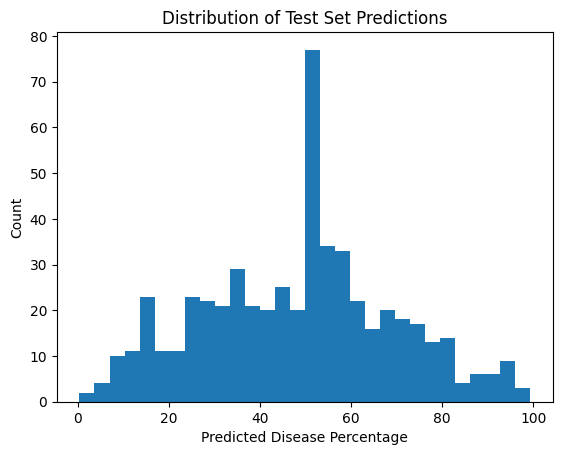

In [15]:
df_pred = pd.read_csv('C:/IIUM/AI Note IIUM/Deep_Learning/Project/Model/Main7.csv')
df_pred['predicted_percentage'] = df_pred['predicted_percentage'].str.strip('[]').astype(float)

plt.hist(df_pred['predicted_percentage'], bins=30)
plt.xlabel('Predicted Disease Percentage')
plt.ylabel('Count')
plt.title('Distribution of Test Set Predictions')
plt.show()